In [20]:
import os
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils import normalize_image, get_sequences, plot_image, plot_images
from dust_analysis import (left_pass_pairs, right_pass_pairs, read_raw_image, read_rectified_image, 
    print_seg_performance, print_seg_dust_performance, get_seg_dust_performance_by_time, get_seg_dust_performance_by_camera_pod)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
def read_csvs(pred_root_dir, model, labeled_dataset):
    pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv'))
    if not 'state' in pred_df:
        pred_df['state'] = pred_df['result_state']
    dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'dust_ratio.csv'))
    print(labeled_dataset, pred_df.shape, dust_df.shape)
    df = pred_df[['unique_id', 'state', 'camera_location', 'operation_time']].merge(dust_df, on='unique_id')
    all_cameras = {'Front Pod': ['T01', 'T02', 'T03', 'T04'], 'Right Pod': ['T05', 'T06', 'T07', 'T08'], 'Rear Pod': ['T09', 'T10', 'T11', 'T12'], 'Left Pod': ['T13', 'T14', 'T15', 'T16']}
    all_cameras = {c: pod for pod, cameras in all_cameras.items() for c in cameras}
    df['pod'] = df.camera_location.apply(lambda c: all_cameras[c])
    return df

def read_pred_csvs(pred_root_dir, model, unlabeled_datasets, labeled_datasets, use_ds, use_label_recovered):
    pred_datasets = []
    for di, use_recovered in zip(use_ds, use_label_recovered):
        if use_recovered:
            pred_datasets.append(unlabeled_datasets[di])
        else:
            pred_datasets.append(labeled_datasets[di])
    pred_dfs = [read_csvs(pred_root_dir, model, ds) for ds in pred_datasets]
    pred_df = pd.concat(pred_dfs, ignore_index=True)
    return pred_df

def read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, use_label_recovered, day_night_split):
    dfs = {'day': [], 'dawn_dusk': [], 'night': []}
    datasets = {}
    assert len(use_ds) == len(use_label_recovered)
    for di, use_recovered in zip(use_ds, use_label_recovered):
        raw_ds, labeled_ds = unlabeled_datasets[di], labeled_datasets[di]
        raw_df = pd.read_csv(os.path.join(data_root_dir, raw_ds, 'annotations.csv'))
        if use_recovered:
            labeled_df = pd.read_csv(os.path.join(data_root_dir, raw_ds, 'label_recovered_master_annotations.csv'))
            datasets[di] = [raw_ds, labeled_df]
        else:
            labeled_df = pd.read_csv(os.path.join(data_root_dir, labeled_ds, 'master_annotations.csv'))
            datasets[di] = [labeled_ds, labeled_df]
        dn_split = day_night_split[di]
        if isinstance(dn_split, str):
            dfs[dn_split].append(labeled_df)
            print(f'load {raw_ds}, get {dn_split} data with {labeled_df.shape}')
        else:
            for dn_split, seq_ids in dn_split.items():
                seq_dfs = get_sequences(raw_df, interval=60)
                dn_raw_df = pd.concat([seq_df for i,seq_df in enumerate(seq_dfs) if i in seq_ids], ignore_index=True)
                dn_df = labeled_df[labeled_df.id.isin(dn_raw_df.id)]
                dfs[dn_split].append(dn_df)
                print(f'load {raw_ds}, get {dn_split} data with {dn_df.shape}')
    dfs = {k: pd.concat(v, ignore_index=True) for k,v in dfs.items()}
    for dn_split, dn_df in dfs.items():
        print(f'{dn_split}: {dn_df.shape}')
    return dfs, datasets

def print_seg_dust_performance(df, model_desc):
    tp_df = df[(df.state == 'true_positive')]
    tn_df = df[(df.state == 'true_negative')]
    fp_df = df[(df.state == 'false_positive')]
    fn_df = df[(df.state == 'false_negative')]
    tp_dust_df = df[df.unique_id.isin(tp_df.unique_id)]
    tn_dust_df = df[df.unique_id.isin(tn_df.unique_id)]
    fp_dust_df = df[df.unique_id.isin(fp_df.unique_id)]
    fn_dust_df = df[df.unique_id.isin(fn_df.unique_id)]
    recall = len(tp_df) / (len(tp_df) + len(fn_df) + 1e-6)
    productivity = len(tn_df) / (len(tn_df) + len(fp_df) + 1e-6)
    print(f'{model_desc}: TP {len(tp_df)}, TN {len(tn_df)}, FP {len(fp_df)}, FN {len(fn_df)}, Recall {recall:.4f}, Productivity {productivity:.4f}')
    print(f'{model_desc} dust: TP {tp_dust_df.total_averaged_dust_conf.mean():.2f}, TN {tn_dust_df.total_averaged_dust_conf.mean():.2f}, FP {fp_dust_df.total_averaged_dust_conf.mean():.2f}, FN {fn_dust_df.total_averaged_dust_conf.mean():.2f}')

def plot_counts_pod_vs_time(pred_df):
    plt.figure(1, figsize=(10, 6))
    idx = np.arange(len(pods))
    width = 0.25
    bars = []
    for ti, t in enumerate(times):
        counts = [len(pred_df[(pred_df.pod.isin(pod)) & (pred_df.id.isin(data_dfs[t].id))]) for pod in pods]
        print(t, counts)
        bar = plt.bar(idx+width*ti, counts, width)
        bars.append(bar)
    plt.xticks(idx+width, ['Front Pod', 'Left & Right Pod', 'Rear Pod'])
    plt.ylabel('Image counts')
    plt.legend(bars, ['Day', 'Dawn_dusk', 'Night'])
    plt.show()

def plot_dust_ratio_vs_pred_state(df, title):
    tp_df = df[df.state == 'true_positive']
    fn_df = df[df.state == 'false_negative']
    print(f'TP {len(tp_df)}, FN {len(fn_df)}, Recall {len(tp_df) / (len(tp_df) + len(fn_df))}')
    plt.figure(1, figsize=(8, 6))
    tp_df.total_averaged_dust_conf.hist(bins=100)
    fn_df.total_averaged_dust_conf.hist(bins=100)
    plt.legend(['TP', 'FN'])
    plt.title(title)
    plt.xlim(0.0, 1.0)
    plt.xlabel('Dust level')
    plt.ylabel('Image count')
    plt.show()

## Human in dust data analysis

In [64]:
data_root_dir = '/data/jupiter/datasets'
unlabeled_datasets = [
    "halo_human_in_dust_day_collection_may29",
    "halo_human_in_dust_night_collection_june03",  # for lying down humans
    "halo_human_in_dust_night_collection_june03_2",
    "halo_human_in_dust_day_collection_back_june05",
]
labeled_datasets = [
    "halo_human_in_dust_day_collection_may29_human_labeled_stereo",
    "halo_human_in_dust_night_collection_june03_human_labeled_stereo",
    "halo_human_in_dust_night_collection_june03_2_human_labeled_stereo",
    "halo_human_in_dust_day_collection_back_june05_human_labeled_stereo",
]
day_night_split = ['day', 'dawn_dusk', {'dawn_dusk': list(range(0, 9)), 'night': list(range(9, 20))}, 'day']
use_ds = [0, 2, 3]
use_label_recovered = [True, False, False]
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
models = [
    'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_10_lo_10_tr_dust_0601',
]

# load data csvs
data_dfs, datasets = read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, use_label_recovered, day_night_split)

# model predictions
mi = 0
pred_df = read_pred_csvs(pred_root_dir, models[mi], unlabeled_datasets, labeled_datasets, use_ds, use_label_recovered)
print(pred_df.shape)

load halo_human_in_dust_day_collection_may29, get day data with (7262, 156)
load halo_human_in_dust_night_collection_june03_2, get dawn_dusk data with (6370, 278)
load halo_human_in_dust_night_collection_june03_2, get night data with (5469, 278)


<ipython-input-64-e2b36a9cb6e2>:24: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  data_dfs, datasets = read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, use_label_recovered, day_night_split)


load halo_human_in_dust_day_collection_back_june05, get day data with (3511, 277)
day: (10773, 279)
dawn_dusk: (6370, 278)
night: (5469, 278)
halo_human_in_dust_day_collection_may29 (7260, 16) (7260, 7)
halo_human_in_dust_night_collection_june03_2_human_labeled_stereo (11839, 16) (11839, 7)
halo_human_in_dust_day_collection_back_june05_human_labeled_stereo (3511, 16) (3511, 7)
(22610, 11)


In [46]:
pred_df.head(2)

,unique_id,state,camera_location,operation_time,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio,pod
0,66595e558b545d525752cfb2_T02_T03,true_positive,T02,daytime,66595e558b545d525752cfb2,0.0,0.124939,0.036865,0.152748,0.047904,Front Pod
1,66595eea568146714ce37514_T02_T03,true_positive,T02,daytime,66595eea568146714ce37514,0.0,0.125615,0.028809,0.125125,0.029940,Front Pod


In [65]:
day_df = pred_df[pred_df.id.isin(data_dfs['day'].id)]
dawn_dusk_df = pred_df[pred_df.id.isin(data_dfs['dawn_dusk'].id)]
night_df = pred_df[pred_df.id.isin(data_dfs['night'].id)]
all_ds_df = pd.concat(data_dfs.values(), ignore_index=True)
print(day_df.shape, dawn_dusk_df.shape, night_df.shape, all_ds_df.shape)

# pods = ['Front Pod', 'Left Pod', 'Right Pod', 'Rear Pod']
pods = [['Front Pod'], ['Left Pod', 'Right Pod'], ['Rear Pod']]
times = ['day', 'dawn_dusk', 'night']
pod_dfs = [pred_df[pred_df.pod.isin(pod)] for pod in pods]
# day_dfs = [pod_df[pod_df.id.isin(data_dfs['day'].id)] for pod_df in pod_dfs]
# dawn_dusk_dfs = [pod_df[pod_df.id.isin(data_dfs['dawn_dusk'].id)] for pod_df in pod_dfs]
# night_dfs = [pod_df[pod_df.id.isin(data_dfs['night'].id)] for pod_df in pod_dfs]

(10771, 11) (6370, 11) (5469, 11) (22612, 280)


day [1347, 3726, 5698]
dawn_dusk [4534, 1459, 377]
night [1579, 2184, 1706]


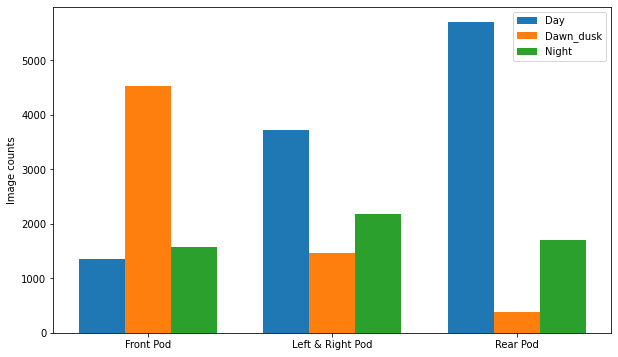

day [696, 1794, 643]
dawn_dusk [950, 1194, 185]
night [1195, 1100, 933]


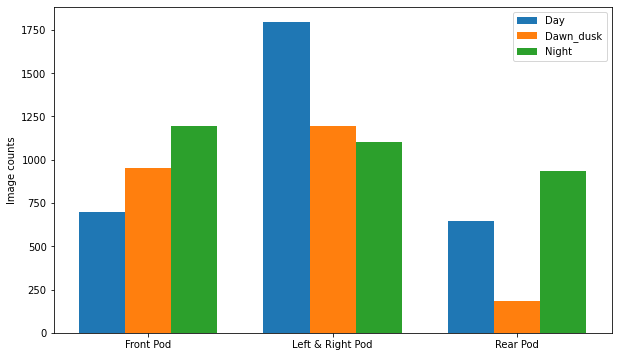

In [58]:
plot_counts_pod_vs_time(pred_df)
plot_counts_pod_vs_time(pred_df[pred_df.total_averaged_dust_conf > 0.05])

TP 13192, FN 761, Recall 0.9454597577581882


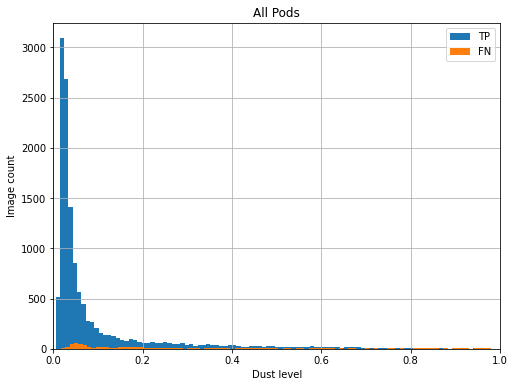

TP 4612, FN 336, Recall 0.9320937752627324


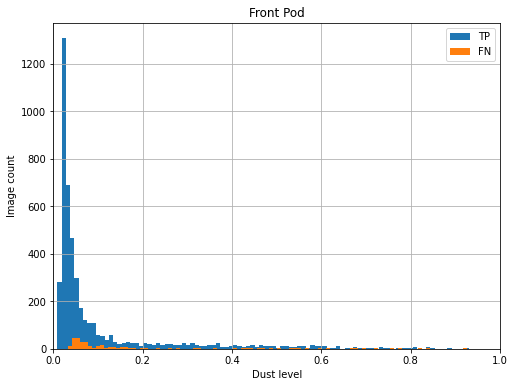

TP 4440, FN 131, Recall 0.9713410632246773


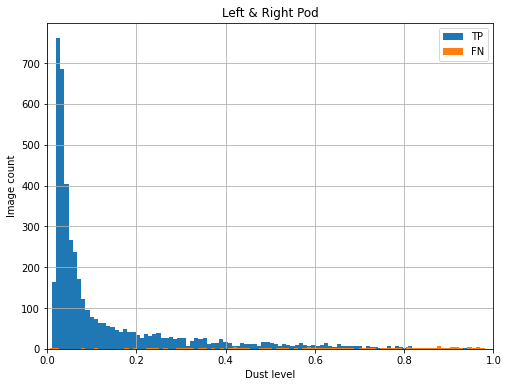

TP 4140, FN 294, Recall 0.9336941813261164


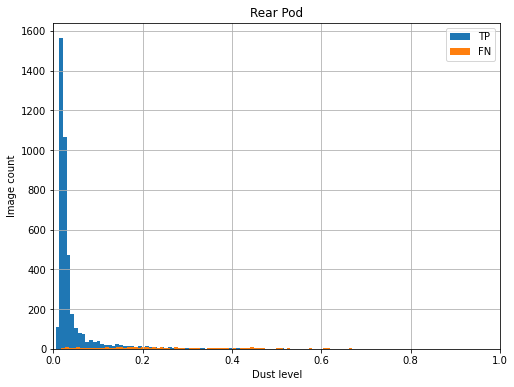

In [59]:
plot_dust_ratio_vs_pred_state(pred_df, 'All Pods')
plot_dust_ratio_vs_pred_state(pod_dfs[0], 'Front Pod')
plot_dust_ratio_vs_pred_state(pod_dfs[1], 'Left & Right Pod')
plot_dust_ratio_vs_pred_state(pod_dfs[2], 'Rear Pod')

## Vehicle in dust data analysis

In [21]:
data_root_dir = '/data/jupiter/datasets'
unlabeled_datasets = [
    "halo_vehicles_in_dust_collection_march2024",
    "halo_vehicles_in_dust_collection_june06",
]
labeled_datasets = [
    "halo_vehicles_in_dust_collection_march2024_vehicle_labeled_stereo",
    "halo_vehicles_in_dust_collection_june06_vehicle_labeled_stereo",
]
day_night_split = [{'day': list(range(0,25)), 'dawn_dusk': list(range(25, 31)), 'night': list(range(31, 38))}, 
                   {'dawn_dusk': list(range(0, 14)), 'night': list(range(14, 29))}]
use_ds = [0, 1]
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
models = [
    'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_10_lo_10_tr_dust_0601',
    # 'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_dust_0601',
]

# load data csvs
data_dfs, datasets = read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, day_night_split)

# model predictions
mi = 0
pred_dfs = [read_csvs(pred_root_dir, models[mi], labeled_datasets[di]) for di in use_ds]
pred_df = pd.concat(pred_dfs, ignore_index=True)
print(pred_df.shape)

load halo_vehicles_in_dust_collection_march2024, get day data with (3922, 259)
load halo_vehicles_in_dust_collection_march2024, get dawn_dusk data with (2094, 259)
load halo_vehicles_in_dust_collection_march2024, get night data with (2164, 259)


<ipython-input-21-1900e0cf92c5>:34: DtypeWarning: Columns (58,75,92,93) have mixed types.Specify dtype option on import or set low_memory=False.
  data_dfs, datasets = read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, day_night_split)


load halo_vehicles_in_dust_collection_june06, get dawn_dusk data with (1092, 269)
load halo_vehicles_in_dust_collection_june06, get night data with (312, 269)
day: (3922, 259)
dawn_dusk: (3186, 274)
night: (2476, 274)
halo_vehicles_in_dust_collection_march2024_vehicle_labeled_stereo (8180, 16) (8180, 7)
halo_vehicles_in_dust_collection_june06_vehicle_labeled_stereo (1404, 16) (1404, 7)
(9584, 11)


In [22]:
day_df = pred_df[pred_df.id.isin(data_dfs['day'].id)]
dawn_dusk_df = pred_df[pred_df.id.isin(data_dfs['dawn_dusk'].id)]
night_df = pred_df[pred_df.id.isin(data_dfs['night'].id)]
all_ds_df = pd.concat(data_dfs.values(), ignore_index=True)
print(day_df.shape, dawn_dusk_df.shape, night_df.shape, all_ds_df.shape)

# pods = ['Front Pod', 'Left Pod', 'Right Pod', 'Rear Pod']
pods = [['Front Pod'], ['Left Pod', 'Right Pod'], ['Rear Pod']]
times = ['day', 'dawn_dusk', 'night']
pod_dfs = [pred_df[pred_df.pod.isin(pod)] for pod in pods]
# day_dfs = [pod_df[pod_df.id.isin(data_dfs['day'].id)] for pod_df in pod_dfs]
# dawn_dusk_dfs = [pod_df[pod_df.id.isin(data_dfs['dawn_dusk'].id)] for pod_df in pod_dfs]
# night_dfs = [pod_df[pod_df.id.isin(data_dfs['night'].id)] for pod_df in pod_dfs]

(3922, 11) (3186, 11) (2476, 11) (9584, 274)


day [514, 1846, 1562]
dawn_dusk [388, 1653, 1145]
night [43, 1255, 1178]


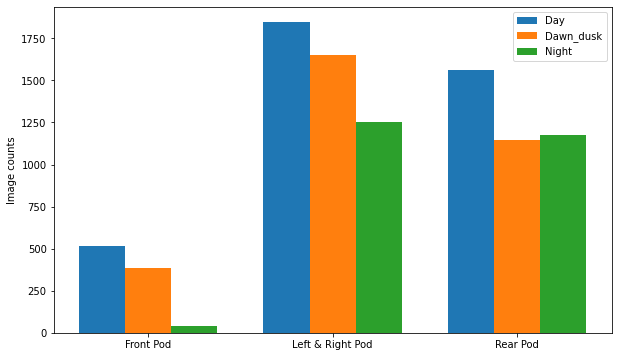

day [3, 532, 1330]
dawn_dusk [28, 377, 1143]
night [3, 801, 1168]


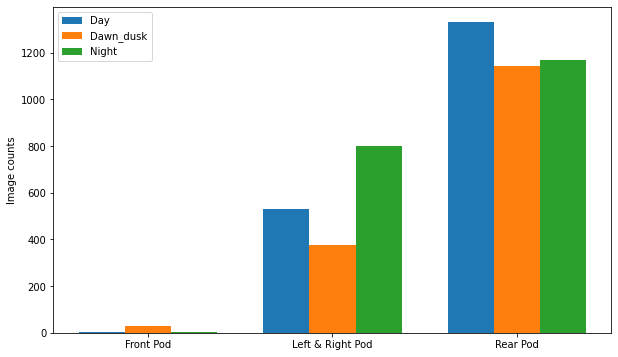

In [26]:
plot_counts_pod_vs_time(pred_df)
plot_counts_pod_vs_time(pred_df[pred_df.total_averaged_dust_conf > 0.05])

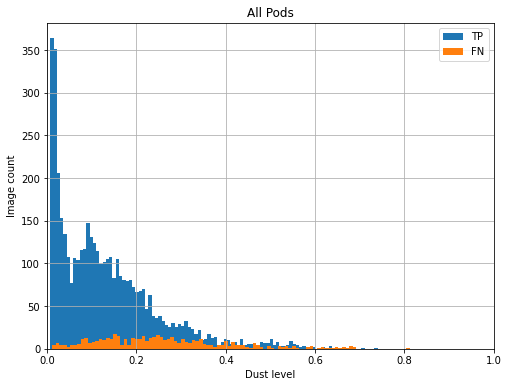

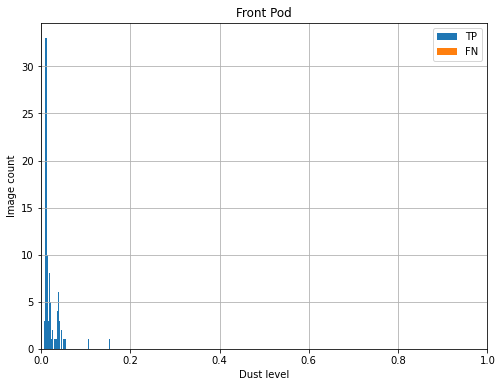

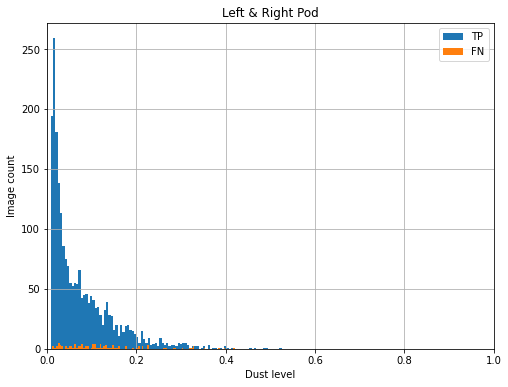

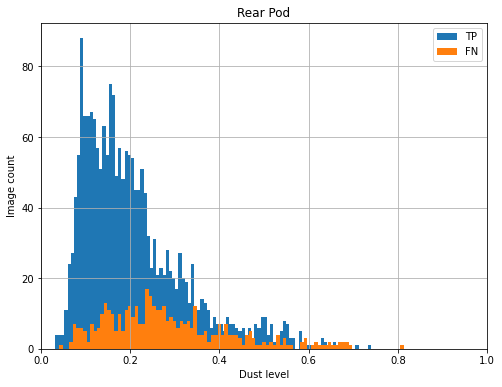

In [27]:
plot_dust_ratio_vs_pred_state(pred_df, 'All Pods')
plot_dust_ratio_vs_pred_state(pod_dfs[0], 'Front Pod')
plot_dust_ratio_vs_pred_state(pod_dfs[1], 'Left & Right Pod')
plot_dust_ratio_vs_pred_state(pod_dfs[2], 'Rear Pod')

## Visualize data

In [66]:
total_df = all_ds_df.drop(columns=['id', 'state', 'camera_location', 'operation_time']).merge(pred_df, on='unique_id')
total_df.shape

(22612, 286)

In [67]:
# df2 = total_df[(total_df.total_averaged_dust_conf > 0.15) & (total_df.state == 'true_positive') & (total_df.pod == 'Left Pod')]
df2 = total_df[(total_df.total_averaged_dust_conf > 0.01) & (total_df.state == 'false_negative') & (total_df.pod == 'Front Pod')]
# df2 = df[(df.total_averaged_dust_conf > 0.25) & (df.state == 'false_negative')]
# df2 = stereo_df[stereo_df.unique_id.isin(df2.unique_id)]
df2.shape

(336, 286)

66596e592c344a7ec9c3f8dd_T02_T03 T02 2024-05-29T20:29:55.661000 daytime 0.056944914


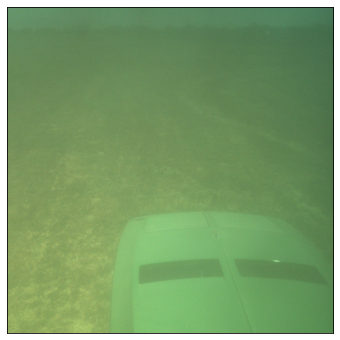

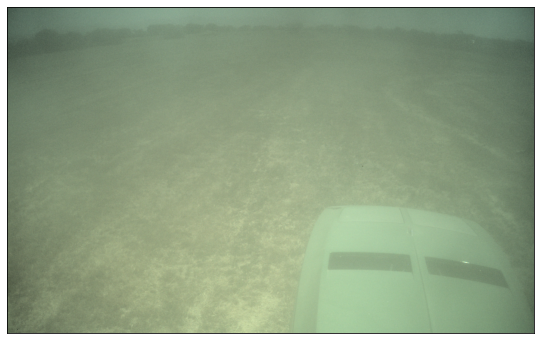

66596e592c344a7ec9c3f8dd_T02_T03 [ 0 11] ['Humans']


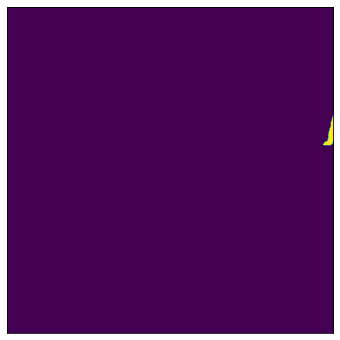

66595d51c9c84e10679c6a1e_T02_T03 T02 2024-05-29T20:30:15.974000 daytime 0.05152945


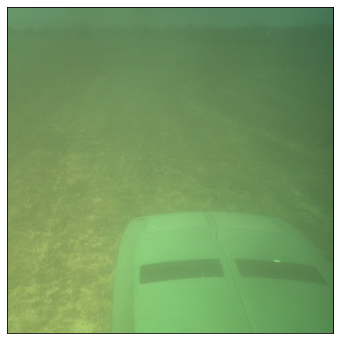

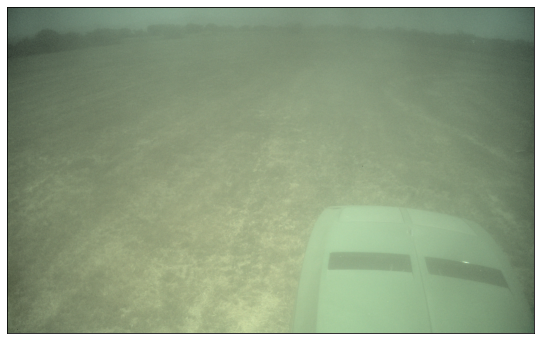

66595d51c9c84e10679c6a1e_T02_T03 [ 0 11] ['Humans']


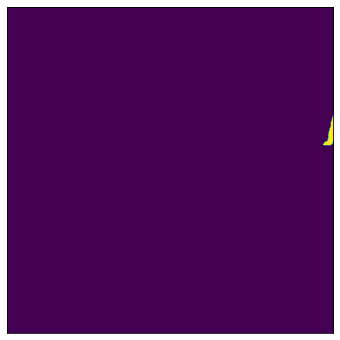

665970d1c05679d08504456b_T02_T03 T02 2024-05-29T19:33:14.066000 daytime 0.44666666


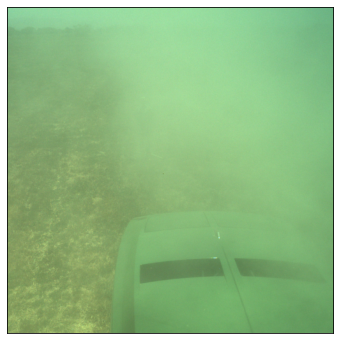

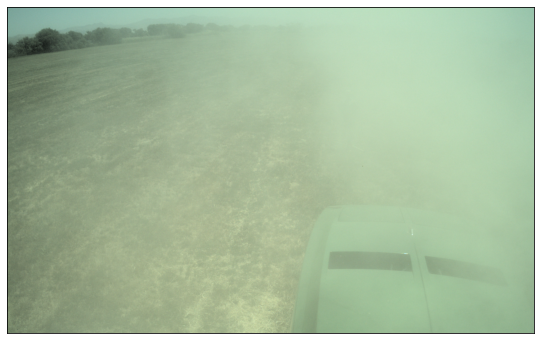

665970d1c05679d08504456b_T02_T03 [ 0 11] ['Humans']


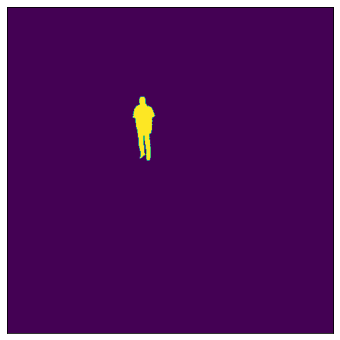

In [74]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
sub_df = df2.sample(3)
show_image, show_label = True, True
show_debayered_rgb, show_raw_label = True, False
show_pred_result = True

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    # print(row.unique_id, row.pred_dust_ratio)
    for di, (dataset, labeled_df) in datasets.items():
        if len(labeled_df[labeled_df.unique_id == row.unique_id]) > 0:
            break
    print(row.unique_id, row.camera_location, row.collected_on, row.operation_time, row.total_averaged_dust_conf)
    if show_image:
        data_path = os.path.join(data_root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=True, return_8_bit=True)
        plot_image(img_norm)

    if show_debayered_rgb:
        # print(os.path.join(data_root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        image = imageio.imread(os.path.join(data_root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(data_root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map = ast.literal_eval(row.label_map)
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 11)

    if show_raw_label:
        label = imageio.imread(os.path.join(data_root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map = ast.literal_eval(row.label_map)
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 11)

    if show_pred_result:
        result_path = os.path.join(pred_root_dir, models[mi], dataset, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))